# Parameter estimation and hypothesis testing

In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
from ipywidgets import interact
%matplotlib inline
sns.set()

## From Bayes Theorem to Bayesian Inference

Let's say that we flip a biased coin several times and we want to estimate the probability of heads from the number of heads we saw. Statistical intuition tells us that our best estimate of $p(heads)=$ number of heads divided by total number of flips.

However, 

1. It doesn't tell us how certain we can be of that estimate and
2. This type of intuition doesn't extend to even slightly more complex examples.

Bayesian inference helps us here. We can calculate the probability of a particular $p=p(H)$ given data $D$ by setting $A$ in Bayes Theorem equal to $p$ and $B$ equal to $D$.


$$P(p|D) = \frac{P(D|p)P(p)}{P(D)} $$



In this equation, we call $P(p)$ the prior (distribution), $P(D|p)$ the likelihood and $P(p|D)$ the posterior (distribution). The intuition behind the nomenclature is as follows: the prior is the distribution containing our knowledge about $p$ prior to the introduction of the data $D$ & the posterior is the distribution containing our knowledge about $p$ after considering the data $D$.

**Key concept:** We only need to know the posterior distribution $P(p|D)$ up to multiplication by a constant at the moment: this is because we really only care about the values of $P(p|D)$ relative to each other – for example, what is the most likely value of $p$? To answer such questions, we only need to know what $P(λ|D)$ is proportional to, as a function of $p$. Thus we don’t currently need to worry about the term $P(D)$. In fact,

$$P(p|D) \propto P(D|p)P(p) $$

**Note:** What is the prior? Really, what do we know about $p$ before we see any data? Well, as it is a probability, we know that $0≤p≤1$. If we haven’t flipped any coins yet, we don’t know much else: so it seems logical that all values of $p$ within this interval are equally likely, i.e., $P(p)=1$, for 0≤λ≤1. This is known as an uninformative prior because it contains little information (there are other uninformative priors we may use in this situation, such as the Jeffreys prior, to be discussed later). People who like to hate on Bayesian inference tend to claim that the need to choose a prior makes Bayesian methods somewhat arbitrary, but as we’ll now see, if you have enough data, the likelihood dominates over the prior and the latter doesn’t matter so much.


**Essential remark:** we get the whole distribution of $P(p|D)$, not merely a point estimate plus errors bars, such as [95% confidence intervals](http://andrewgelman.com/2018/07/04/4th-july-lets-declare-independence-95/).


Now let's generate some coin flips and try to estimate $p(H)$. Two notes:
- given data $D$ consisting of $n$ coin tosses & $k$ heads, the likelihood function is given by $L:=P(D|p) \propto p^k(1−p)^{n−k}$;
- given a uniform prior, the posterior is proportional to the likelihood.

In [2]:
def plot_posterior(p=0.6, N=0):
    """Plot the posterior given a uniform prior; Bernoulli trials
    with probability p; sample size N"""
    np.random.seed(42)
    # Flip coins 
    n_successes = np.random.binomial(N, p)
    # X-axis for PDF
    x = np.linspace(0, 1, 100)
    #prior
    prior = 1
    posterior = x**n_successes*(1-x)**(N-n_successes)*prior
    posterior /= np.max(posterior)  # so that peak always at 1
    plt.plot(x, posterior)
    plt.show()

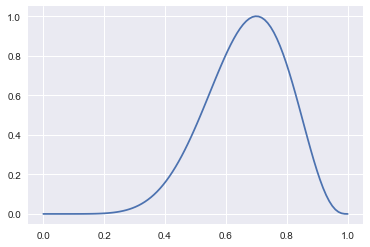

In [3]:
plot_posterior(N=10)

* Now use the great ipywidget interact to check out the posterior as you generate more and more data (you can also vary $p$):

In [4]:
interact(plot_posterior, p=(0, 1, 0.01), N=(0, 1500));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

**Notes for discussion:**

* as you generate more and more data, your posterior gets narrower, i.e. you get more and more certain of your estimate.
* you need more data to be certain of your estimate when $p=0.5$, as opposed to when $p=0$ or $p=1$. 

### Other priors

But wait! We've had to specify a prior. Discuss specification of priors. Motivate Jeffries prior and show equation for it. 

### Hands-on

* Create an interactive plot like the one above, except that it has two posteriors on it: one for the uniform prior, another for the Jeffries prior.

In [5]:
# Solution
def plot_posteriors(p=0.6, N=0):
    np.random.seed(42)
    n_successes = np.random.binomial(N, p)
    x = np.linspace(0.01, 0.99, 100)
    posterior1 = x**n_successes*(1-x)**(N-n_successes)  # w/ uniform prior
    posterior1 /= np.max(posterior1)  # so that peak always at 1
    plt.plot(x, posterior1, label='Uniform prior')
    jp = np.sqrt(x*(1-x))**(-1)  # Jeffreys prior
    posterior2 = posterior1*jp  # w/ Jeffreys prior
    posterior2 /= np.max(posterior2)  # so that peak always at 1 (not quite correct to do; see below)
    plt.plot(x, posterior2, label='Jeffreys prior')
    plt.legend()
    plt.show()

In [6]:
interact(plot_posteriors, p=(0, 1, 0.01), N=(0, 100));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

**Question:** What happens to the posteriors as you generate more and more data?

## Bayesian parameter estimation using PyMC3

In [7]:
# click-through rates
p_a = 0.15
N = 150
n_successes_a = np.sum(np.random.binomial(N,p_a))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_interval__]
100%|██████████| 1500/1500 [00:00<00:00, 2294.81it/s]


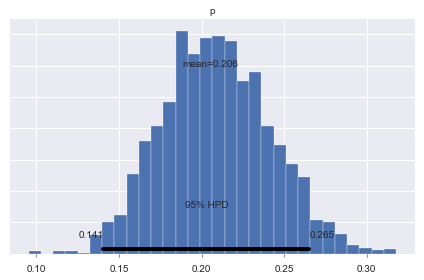

In [8]:
# Build model of p_a
with pm.Model() as Model:
    # Prior on p
    prob = pm.Uniform('p')
    # Binomial Likelihood
    y = pm.Binomial('y', n=N, p=prob, observed=n_successes_a)

with Model:
    samples = pm.sample(1000, njobs=1)

pm.plot_posterior(samples);

## Parameter estimation II: the mean of a population



### Hands-on

In this exercise, you'll calculate the  posterior mean beak depth of Galapagos finches.

In [9]:
# Import and view head of data
df_12 = pd.read_csv('../data/finch_beaks_2012.csv')
df_fortis = df_12.loc[df_12.species == 'fortis']
df_scandens = df_12.loc[df_12.species == 'scandens']

In [10]:
with pm.Model() as model:
    """
    The priors for each group.
    """
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Lognormal('σ_1', 0, 10)
    # Gaussian Likelihood
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis.blength)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_1_log__, μ_1]
100%|██████████| 2500/2500 [00:01<00:00, 1651.80it/s]


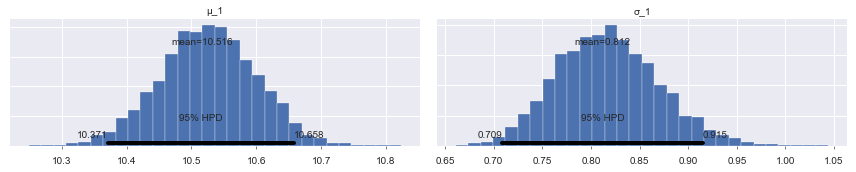

In [11]:
# bust it out & sample
with model:
    samples = pm.sample(2000, njobs=1)
    
pm.plot_posterior(samples);

## Bayesian Hypothesis testing

### Instruction: A/B tests on click through rates

Assume we have a website and want to redesign the layout (_A_) and test whether the new layout (_B_) results in a higher click through rate. When people come to our website we randomly show them layout _A_ or _B_ and see how many people click through for each. First let's generate the data we need:

In [12]:
# click-through rates
p_a = 0.15
p_b = 0.20
N = 1000
n_successes_a = np.sum(np.random.uniform(size=N) <= p_a)
n_successes_b = np.sum(np.random.uniform(size=N) <= p_b)

In [13]:
with pm.Model() as Model:
    # Prior on p
    prob_a = pm.Uniform('p_a')
    prob_b = pm.Uniform('p_b')
    # Binomial Likelihood
    y_a = pm.Binomial('y_a', n=N, p=prob_a, observed=n_successes_a)
    y_b = pm.Binomial('y_b', n=N, p=prob_b, observed=n_successes_b)
    diff_clicks = pm.Deterministic('diff_clicks', prob_a-prob_b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_b_interval__, p_a_interval__]
100%|██████████| 1500/1500 [00:01<00:00, 1326.50it/s]


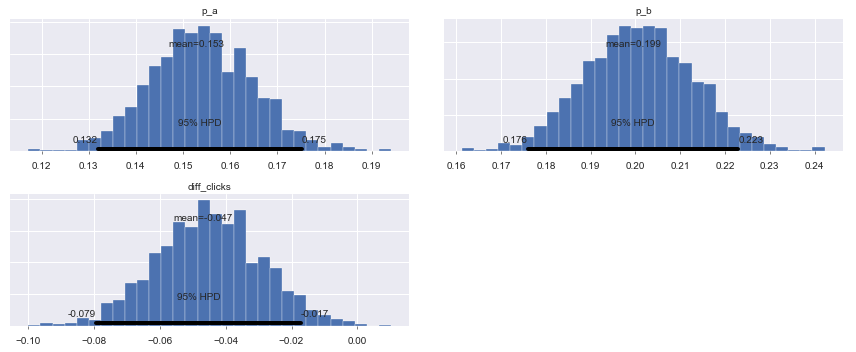

In [14]:
with Model:
    samples = pm.sample(1000, njobs=1)
pm.plot_posterior(samples);

### Hands-on: beak shape difference over 50 years in Galapagos finches

**Task**: Determine whether the mean beak length of the Galapogas finches differs between species.

In [15]:
with pm.Model() as model:
    """
    The priors for each group.
    """
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Lognormal('σ_1', 0, 10)
    μ_2 = pm.Normal('μ_2', mu=10, sd=5)
    σ_2 = pm.Lognormal('σ_2', 0, 10)
    # Gaussian Likelihoods
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis.blength)
    y_2 = pm.Normal('y_2', mu=μ_2, sd=σ_2, observed=df_scandens.blength)
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', μ_1 - μ_2)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(σ_1, 2) + 
                                         np.power(σ_2, 2)) / 2)
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_2_log__, μ_2, σ_1_log__, μ_1]
100%|██████████| 2500/2500 [00:02<00:00, 967.24it/s]


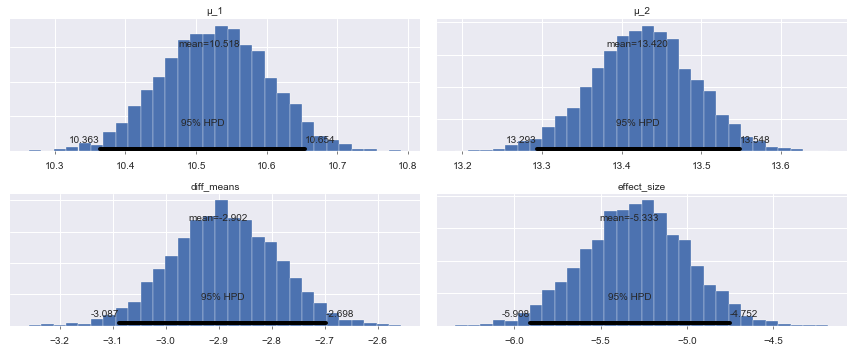

In [16]:
# bust it out & sample
with model:
    samples = pm.sample(2000, njobs=1)
pm.plot_posterior(samples, varnames=['μ_1', 'μ_2', 'diff_means', 'effect_size']);